<a href="https://colab.research.google.com/github/mahtab71/Smallplaces/blob/main/svm_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load CIFAR-10 dataset
training_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:03<00:00, 43538662.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:

batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:

# Define loss function and optimizer
criterion = nn.MultiMarginLoss(p=1) # Hinge Loss
#criterion = nn.MultiMarginLoss()  # Hinge Loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / (i + 1)}")

print("Finished Training")

Epoch [1/20] Loss: 0.8990426451501334
Epoch [2/20] Loss: 0.8926146685924676
Epoch [3/20] Loss: 0.7227348165820017
Epoch [4/20] Loss: 0.5777470817041519
Epoch [5/20] Loss: 0.5470293164253235
Epoch [6/20] Loss: 0.5202276118271186
Epoch [7/20] Loss: 0.4879462510880912
Epoch [8/20] Loss: 0.44595531471397565
Epoch [9/20] Loss: 0.4119307248260054
Epoch [10/20] Loss: 0.38976936368152615
Epoch [11/20] Loss: 0.3684657792110577
Epoch [12/20] Loss: 0.3534713655405337
Epoch [13/20] Loss: 0.3427508618025219
Epoch [14/20] Loss: 0.3334191741274141
Epoch [15/20] Loss: 0.32475449485928204
Epoch [16/20] Loss: 0.31701853057688767
Epoch [17/20] Loss: 0.3134544063597689
Epoch [18/20] Loss: 0.30961274308011966
Epoch [19/20] Loss: 0.302389595800501
Epoch [20/20] Loss: 0.2979115681422641
Finished Training


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_dataloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)    #ino nafahmidam
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images is: {100* correct // total}% ')

Accuracy of the network on the 10000 test images is: 49% 


# **ROC**

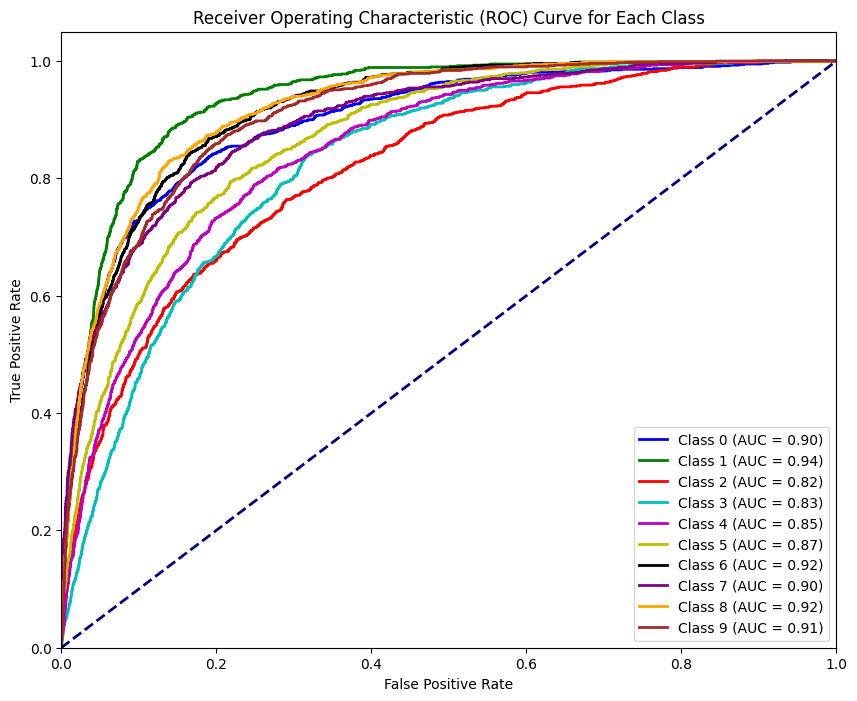

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

# ... (previous code)

# Initialize empty lists to store true labels and predicted scores for each class
true_labels = [[] for _ in range(10)]
predicted_scores = [[] for _ in range(10)]

# Set the model to evaluation mode
net.eval()

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        predicted_probs = F.softmax(outputs, dim=1).cpu().numpy()

        for i in range(10):
            true_labels[i].extend((labels == i).cpu().numpy())
            predicted_scores[i].extend(predicted_probs[:, i])

# Calculate ROC curves and AUC for each class
fpr = []
tpr = []
roc_auc = []

for i in range(10):
    fpr_i, tpr_i, _ = roc_curve(true_labels[i], predicted_scores[i])
    roc_auc_i = auc(fpr_i, tpr_i)
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'brown']

for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

# **confusion matrix**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

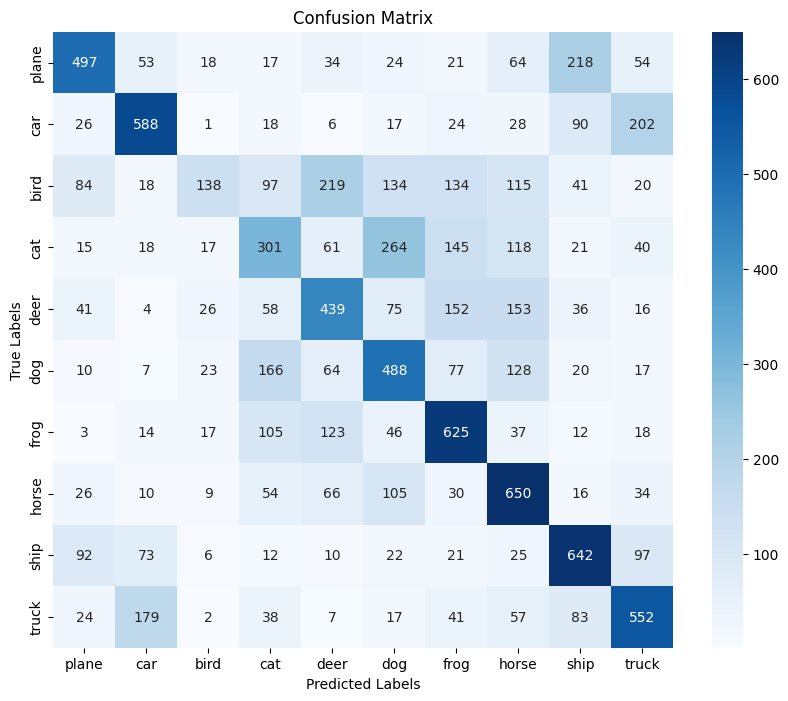

In [ ]:
# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
net.eval()

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        # Append true labels and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

decision tree

In [ ]:
import torchvision
from torchvision.transforms import ToTensor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load CIFAR-10 dataset
training_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64

# Create data loaders (not needed for decision trees)
# We'll load the entire dataset into memory since decision trees don't require mini-batch training
train_loader = torch.utils.data.DataLoader(training_data, batch_size=len(training_data), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Extract the data and labels
train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))

# Flatten the image data
train_data = train_data.view(train_data.size(0), -1)
test_data = test_data.view(test_data.size(0), -1)

accuracy = accuracy_score(test_labels, test_predictions)

print(f'Accuracy of the decision tree on the test data: {accuracy * 100:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Accuracy of the decision tree on the test data: 26.90%
